In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.precision", 4)

from modules.helpers import parseMatrixRows, parseMatrixColumns, parseMatrixIndexes
from modules.plot import highlightNotZero, plotSchema


from modules.model_2z import Point, Bar, BarProps
from modules.matrices_2z import LoadMatrix, BarMatrices, modelMatrix
from modules.internalForces_2z import *

## Vstupy

In [2]:
crossSection = {"width": 200, "height": 300}
material = "C30/37"
barProps = BarProps(material, crossSection)
print(f'E = {barProps.E} kPa \nI = {barProps.I} m-4\nA = {barProps.A} m2')

E = 33000000.0 kPa 
I = 0.00044999999999999993 m-4
A = 0.06 m2


In [3]:
F = 40 #kN
K = F
Q = 5 #kN/m
load_bar12 = Load(K=K, K_position=0.5)
load_bar23 = Load(F = F, F_position=0.5)
load_bar34 = Load(Q=Q)

In [4]:
p1 = Point(0, 0, "bod 1", [0,1,2])
p2 = Point(0, -3, "bod 2", [3,4,5])
p3 = Point(3, -3, "bod 3", [6,7,8])
p4 = Point(3, 0, "bod 4", [9,10,11])


In [5]:
p1.stiff #votknutie v bode 1
p4.free_fi_x #klbova podpera v bode 4
print(f'p1 = {p1}\n p2 = {p2}\n p3 = {p3}\n p4 = {p4}')

p1 = Point(x=0, y=0, name='bod 1', codeNumbers=[0, 1, 2], dof=[0, 0, 0])
 p2 = Point(x=0, y=-3, name='bod 2', codeNumbers=[3, 4, 5], dof=[1, 1, 1])
 p3 = Point(x=3, y=-3, name='bod 3', codeNumbers=[6, 7, 8], dof=[1, 1, 1])
 p4 = Point(x=3, y=0, name='bod 4', codeNumbers=[9, 10, 11], dof=[0, 1, 0])


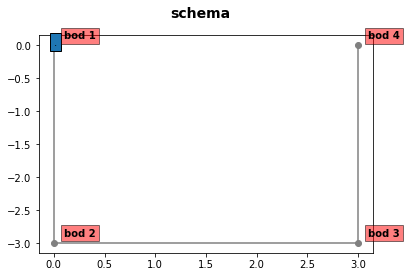

In [6]:
plotSchema([p1,p2,p3,p4])

In [7]:
bar12 = Bar(p1, p2)
bar23 = Bar(p2, p3)
bar34 = Bar(p3, p4)
print(f'bar12 = {bar12.len} m \nbar23 = {bar23.len} m\nbar34 = {bar34.len} m')

bar12 = 3.0 m 
bar23 = 3.0 m
bar34 = 3.0 m


In [8]:
def barSolution(bar, barProps, load):
    # print bar geometry
    [lx, ly] = bar.l_xy
    alfa = bar.angle
    print(f'bar properties \nalfa = {alfa} deg')
    print(f'lx = {lx}\nly = {ly}')

    # print stiffness matrix
    bar_matrices = BarMatrices(barProps, bar)
    A0 = bar_matrices.rotation
    B0 = bar_matrices.transmission
    k = bar_matrices.gss_stiffness
    k = parseMatrixIndexes(k, bar.codeNumbers)
    print('------------------------')
    print(
        f'stiffness matrix \n{k}\n rotation matrix \n{A0}\n transmission matrix \n{B0}')

    # calculate primary internal forces
    IntF = InternalForces_primary(load, bar)

    # print load vector
    FA_l = LoadMatrix.lss(IntF.Va, IntF.Ka, IntF.Ma)
    FB_l = LoadMatrix.lss(IntF.Vb, IntF.Kb, IntF.Mb)
    FA_g = LoadMatrix.gss(FA_l, A0.T)
    FB_g = LoadMatrix.gss(FB_l, A0.T)

    F = LoadMatrix.super(FA_g, FB_g)
    F = parseMatrixRows(F, bar.codeNumbers)
    print('------------------------')
    print(f'load vector \n{F}')

    toReturn = {
        "bar" : bar,
        "barProps": barProps,
        "lx" : lx,
        "ly" : ly,
        "alfa" : alfa,
        "A0" : A0,
        "B0" : B0,
        "k" : k,
        "F" : F,
        "FA_g" : FA_g,
        "FB_g" : FB_g,
        "FA_l" : FA_l,
        "FB_l" : FB_l,
        "IntF": IntF
    }
    return toReturn


In [9]:
bar12_Solution = barSolution(bar12, barProps, load_bar12)

bar properties 
alfa = 90.0 deg
lx = 0
ly = 3
------------------------
stiffness matrix 
            0           1           2           3           4           5
0  6.6000e+03  9.9000e+03 -6.0620e-13 -6.6000e+03  9.9000e+03  6.0620e-13
1  9.9000e+03  1.9800e+04 -1.0806e-12 -9.9000e+03  9.9000e+03  1.0806e-12
2 -6.0620e-13 -1.0806e-12  2.1518e+03  6.0620e-13 -7.3796e-13 -2.1518e+03
3 -6.6000e+03 -9.9000e+03  6.0620e-13  6.6000e+03 -9.9000e+03 -6.0620e-13
4  9.9000e+03  9.9000e+03 -7.3796e-13 -9.9000e+03  1.9800e+04  7.3796e-13
5  6.0620e-13  1.0806e-12 -2.1518e+03 -6.0620e-13  7.3796e-13  2.1518e+03
 rotation matrix 
   0           1           2
0  1  0.0000e+00  0.0000e+00
1  0  6.1232e-17  1.0000e+00
2  0 -1.0000e+00  6.1232e-17
 transmission matrix 
   0  1  2
0 -1  0  0
1  3 -1  0
2  0  0 -1
------------------------
load vector 
            0
0  0.0000e+00
1 -1.2246e-15
2 -2.0000e+01
3  0.0000e+00
4 -1.2246e-15
5 -2.0000e+01


In [10]:
bar12_Solution["IntF"]

InternalForces_primary(load=Load(Q=0, F=0, F_position=0.5, K=40, K_position=0.5), Ma=0, Mb=0, Va=0, Vb=0, Ka=-20.0, Kb=-20.0)

In [11]:
bar23_Solution = barSolution(bar23,barProps, load_bar23)

bar properties 
alfa = 0.0 deg
lx = 3
ly = 0
------------------------
stiffness matrix 
        3          4        5       6          7        8
3  6600.0     0.0000  -9900.0 -6600.0     0.0000  -9900.0
4     0.0  2151.7742      0.0     0.0 -2151.7742      0.0
5 -9900.0     0.0000  19800.0  9900.0     0.0000   9900.0
6 -6600.0     0.0000   9900.0  6600.0     0.0000   9900.0
7     0.0 -2151.7742      0.0     0.0  2151.7742      0.0
8 -9900.0     0.0000   9900.0  9900.0     0.0000  19800.0
 rotation matrix 
   0    1    2
0  1  0.0  0.0
1  0  1.0  0.0
2  0 -0.0  1.0
 transmission matrix 
   0  1  2
0 -1  0  0
1  0 -1  0
2 -3  0 -1
------------------------
load vector 
      0
3  20.0
4   0.0
5 -15.0
6  20.0
7   0.0
8  15.0


In [12]:
bar34_Solution = barSolution(bar34, barProps, load_bar34)

bar properties 
alfa = -90.0 deg
lx = 0
ly = -3
------------------------
stiffness matrix 
            6           7           8           9           10          11
6   6.6000e+03 -9.9000e+03 -6.0620e-13 -6.6000e+03 -9.9000e+03  6.0620e-13
7  -9.9000e+03  1.9800e+04  1.0806e-12  9.9000e+03  9.9000e+03 -1.0806e-12
8  -6.0620e-13  1.0806e-12  2.1518e+03  6.0620e-13  7.3796e-13 -2.1518e+03
9  -6.6000e+03  9.9000e+03  6.0620e-13  6.6000e+03  9.9000e+03 -6.0620e-13
10 -9.9000e+03  9.9000e+03  7.3796e-13  9.9000e+03  1.9800e+04 -7.3796e-13
11  6.0620e-13 -1.0806e-12 -2.1518e+03 -6.0620e-13 -7.3796e-13  2.1518e+03
 rotation matrix 
   0           1           2
0  1  0.0000e+00  0.0000e+00
1  0  6.1232e-17 -1.0000e+00
2  0  1.0000e+00  6.1232e-17
 transmission matrix 
   0  1  2
0 -1  0  0
1 -3 -1  0
2  0  0 -1
------------------------
load vector 
             0
6   7.5000e+00
7  -3.7500e+00
8  -2.2962e-16
9   7.5000e+00
10  3.7500e+00
11  2.2962e-16


In [13]:
k1 = bar12_Solution['k']
k2 = bar23_Solution['k']
k3 = bar34_Solution['k']


In [14]:
modelMatrix_ = modelMatrix([k1,k2,k3])
modelMatrix_.style\
.format('{:.2e}')\
.applymap(highlightNotZero)

,0,1,2,3,4,5,6,7,8,9,10,11
0,6.60e+03,9.90e+03,-6.06e-13,-6.60e+03,9.90e+03,6.06e-13,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
1,9.90e+03,1.98e+04,-1.08e-12,-9.90e+03,9.90e+03,1.08e-12,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
2,-6.06e-13,-1.08e-12,2.15e+03,6.06e-13,-7.38e-13,-2.15e+03,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
3,-6.60e+03,-9.90e+03,6.06e-13,1.32e+04,-9.90e+03,-9.90e+03,-6.60e+03,0.00e+00,-9.90e+03,0.00e+00,0.00e+00,0.00e+00
4,9.90e+03,9.90e+03,-7.38e-13,-9.90e+03,2.20e+04,7.38e-13,0.00e+00,-2.15e+03,0.00e+00,0.00e+00,0.00e+00,0.00e+00
5,6.06e-13,1.08e-12,-2.15e+03,-9.90e+03,7.38e-13,2.20e+04,9.90e+03,0.00e+00,9.90e+03,0.00e+00,0.00e+00,0.00e+00
6,0.00e+00,0.00e+00,0.00e+00,-6.60e+03,0.00e+00,9.90e+03,1.32e+04,-9.90e+03,9.90e+03,-6.60e+03,-9.90e+03,6.06e-13
7,0.00e+00,0.00e+00,0.00e+00,0.00e+00,-2.15e+03,0.00e+00,-9.90e+03,2.20e+04,1.08e-12,9.90e+03,9.90e+03,-1.08e-12
8,0.00e+00,0.00e+00,0.00e+00,-9.90e+03,0.00e+00,9.90e+03,9.90e+03,1.08e-12,2.20e+04,6.06e-13,7.38e-13,-2.15e+03
9,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,-6.60e+03,9.90e+03,6.06e-13,6.60e+03,9.90e+03,-6.06e-13


In [15]:
def boundaryConditionsVector(points: list) -> list:
    dofList=[]
    for point in points:
        dofList.append(point.dof)
    return pd.DataFrame(np.array(dofList).flatten())
    
def boundaryConditionsFilter(bc_vector, cond):
    bc = np.array(bc_vector).flatten()
    df = pd.DataFrame(bc)
    return df[df[0]==cond].index.values.astype(int)

def loadVector(F1,F2,F3):
    x = F1.add(F2,fill_value=0)
    return x.add(F3,fill_value=0)


In [16]:
F1 = bar12_Solution['F']
F2 = bar23_Solution['F']
F3 = bar34_Solution['F']

In [17]:
loadVector_ = loadVector(F1,F2,F3)
loadVector_

,0
0,0.0000e+00
1,-1.2246e-15
2,-2.0000e+01
3,2.0000e+01
4,-1.2246e-15
5,-3.5000e+01
6,2.7500e+01
7,-3.7500e+00
8,1.5000e+01
9,7.5000e+00


In [18]:
bc_vector = boundaryConditionsVector([p1,p2,p3,p4])
bc_0 = boundaryConditionsFilter(bc_vector, 0)
loadVector_.drop(bc_0, inplace=True)
loadVector_

,0
3,2.0000e+01
4,-1.2246e-15
5,-3.5000e+01
6,2.7500e+01
7,-3.7500e+00
8,1.5000e+01
10,3.7500e+00


In [19]:
bc_1 = boundaryConditionsFilter(bc_vector, 1)
copyModelMatrix = modelMatrix_.copy()
copyModelMatrix.drop(bc_0, inplace=True)
filteredModelMatrix = copyModelMatrix[bc_1]
parseMatrixIndexes(filteredModelMatrix.copy(), ["w[2]", "fi_x[2]", "fi_y[2]","w[3]", "fi_x[3]", "fi_y[3]","fi_x[4]"])

,w[2],fi_x[2],fi_y[2],w[3],fi_x[3],fi_y[3],fi_x[4]
w[2],13200.0,-9.9000e+03,-9.9000e+03,-6600.0,0.0000e+00,-9.9000e+03,0.0000e+00
fi_x[2],-9900.0,2.1952e+04,7.3796e-13,0.0,-2.1518e+03,0.0000e+00,0.0000e+00
fi_y[2],-9900.0,7.3796e-13,2.1952e+04,9900.0,0.0000e+00,9.9000e+03,0.0000e+00
w[3],-6600.0,0.0000e+00,9.9000e+03,13200.0,-9.9000e+03,9.9000e+03,-9.9000e+03
fi_x[3],0.0,-2.1518e+03,0.0000e+00,-9900.0,2.1952e+04,1.0806e-12,9.9000e+03
fi_y[3],-9900.0,0.0000e+00,9.9000e+03,9900.0,1.0806e-12,2.1952e+04,7.3796e-13
fi_x[4],0.0,0.0000e+00,0.0000e+00,-9900.0,9.9000e+03,7.3796e-13,1.9800e+04


In [20]:
def nodeDisplacements(modelMatrix):
    inv = pd.DataFrame(np.linalg.inv(modelMatrix.values), modelMatrix.columns, modelMatrix.index)
    return inv.dot(loadVector_)*-1

In [21]:
displacements = nodeDisplacements(filteredModelMatrix)
parseMatrixRows(displacements.copy(), ["w[2]", "fi_x[2]", "fi_y[2]","w[3]", "fi_x[3]", "fi_y[3]","fi_x[4]"])

,0
w[2],-0.0312
fi_x[2],-0.0168
fi_y[2],0.0204
w[3],-0.0891
fi_x[3],-0.0277
fi_y[3],0.0163
fi_x[4],-0.0309


In [22]:
def modelDisplacements(displacements):
     return pd.DataFrame(np.zeros((12, 1))).add(displacements, fill_value=0)

In [23]:
modelDisplacements = modelDisplacements(displacements)
rows = ["w[1]", "fi_x[1]", "fi_y[1]", "w[2]", "fi_x[2]", "fi_y[2]","w[3]", "fi_x[3]", "fi_y[3]", "w[4]", "fi_x[4]", "fi_y[4]",]
parseMatrixRows(modelDisplacements.copy(), rows)

,0
w[1],0.0000
fi_x[1],0.0000
fi_y[1],0.0000
w[2],-0.0312
fi_x[2],-0.0168
fi_y[2],0.0204
w[3],-0.0891
fi_x[3],-0.0277
fi_y[3],0.0163
w[4],0.0000


In [24]:
# calculate internal forces by formula --- F = F' + k * delta
def barInternalForces(modelDisplacements, barSolution):

    bar = barSolution["bar"]
    barProps = barSolution["barProps"]

    # get bar displacements (delta)
    delta_1 = modelDisplacements.loc[bar.codeNumbers[0]:bar.codeNumbers[2]]
    delta_2 = modelDisplacements.loc[bar.codeNumbers[3]:bar.codeNumbers[5]]
    deltaBar = pd.concat([delta_1, delta_2])

    
    # get bar matrices
    A0 = barSolution["A0"]
    k = barSolution["k"]

    # u = k * delta
    u = k.dot(deltaBar)

    # F' --- node A
    A0_A_parsed = parseMatrixIndexes(A0, bar.codeNumbers[0:3])
    FA_g = barSolution["FA_g"]
    F_A_g_parsed = parseMatrixRows(FA_g, bar.codeNumbers[0:3])

    # F' --- node B
    A0_B_parsed = parseMatrixIndexes(A0, bar.codeNumbers[3:6])
    FB_g = barSolution["FB_g"]
    F_B_g_parsed = parseMatrixRows(FB_g, bar.codeNumbers[3:6])


    # F' + u --- node A
    local = u.loc[bar.codeNumbers[0]:bar.codeNumbers[2]]+F_A_g_parsed
    F1 = A0_A_parsed.T.dot(local)
    forces_AB = parseMatrixRows(F1, ["V","T","M"])

    # F' + u --- node B
    local = u.loc[bar.codeNumbers[3]:bar.codeNumbers[5]]+F_B_g_parsed
    F2 = A0_B_parsed.dot(local)
    forces_BA = parseMatrixRows(F2, ["V","T","M"])

    forces = pd.concat([forces_AB, forces_BA], axis=1)
    print(parseMatrixColumns(forces, [bar.point_a.name, bar.point_b.name]))
    return forces

    


In [25]:
forces12 = barInternalForces(modelDisplacements, bar12_Solution)

      bod 1    bod 2
V   39.6324 -39.6324
T   63.9122  23.9122
M  142.5000  23.6028


In [26]:
forces23 = barInternalForces(modelDisplacements, bar23_Solution)

     bod 2    bod 3
V  39.6324   0.3676
T  23.6028 -23.6028
M -23.9122 -34.9850


In [27]:
forces34 = barInternalForces(modelDisplacements, bar34_Solution)

     bod 3       bod 4
V  -0.3676  1.5368e+01
T  34.9850  3.4985e+01
M -23.6028  1.3020e-13


In [28]:
forces_final = pd.concat([forces12, forces23, forces34], axis=1)
forces_final

,bod 1,bod 2,bod 2,bod 3,bod 3,bod 4
V,39.6324,-39.6324,39.6324,0.3676,-0.3676,1.5368e+01
T,63.9122,23.9122,23.6028,-23.6028,34.9850,3.4985e+01
M,142.5000,23.6028,-23.9122,-34.9850,-23.6028,1.3020e-13
